In [2]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy
from numpy.polynomial.chebyshev import chebval
from scipy.linalg import fractional_matrix_power

## Theory of Chebyshev Polynomials

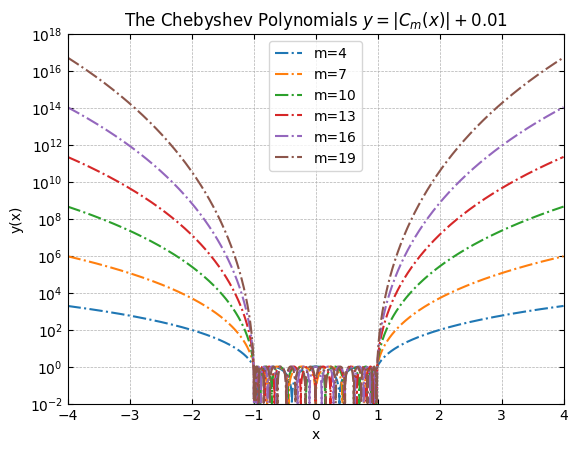

In [104]:
#Create an array from -2 to 2 with 1000 points
x = np.linspace(-4, 4, 100000)

#Write a code for finding m the first kind chev_0yshev polynomial
m = 20
T = np.zeros((m, x.size))
T[0] = np.ones(x.size)
T[1] = x
C=np.zeros((m, x.size))
for i in range(2, m):
    T[i] = 2*x*T[i-1] - T[i-2] + 0.01

for i in range (m):
    C[i] = np.abs(T[i])+0.01

#Plot the first kind chebyshev polynomial
plt.figure()
for i in range(4,m,3):
    plt.plot(x, C[i], label="m={}".format(i), linestyle="-.")
plt.legend()
plt.xlabel("x")
plt.ylabel("y(x)")
# y range from 10^-2 to 10^18
plt.ylim(1e-2, 1e18)
plt.xlim(-4, 4)
#y in semi log
plt.yscale("log")
# show ticks on both sides
plt.tick_params(axis='both', direction='in')
# Show ticks on right as well as top
plt.tick_params(top=True, right=True)
# Add labels on y axis after 10^2
plt.yticks([1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10, 1e12, 1e14, 1e16, 1e18], ["$10^{-2}$", "$10^{0}$", "$10^{2}$", "$10^{4}$", "$10^{6}$", "$10^{8}$", "$10^{10}$", "$10^{12}$", "$10^{14}$", "$10^{16}$", "$10^{18}$"])

plt.title("The Chebyshev Polynomials $y = |C_m(x)|+0.01$")
plt.grid( linestyle='--', linewidth=0.5)
plt.show()


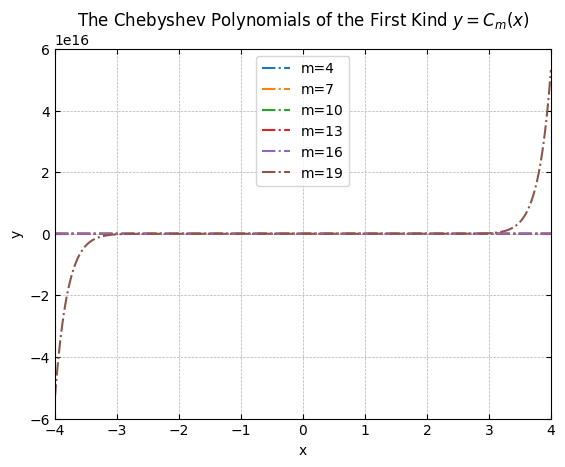

In [105]:
plt.figure()
for i in range(4,m,3):
    plt.plot(x, T[i], label="m={}".format(i), linestyle="-.")
plt.legend( loc='upper center')
plt.xlabel("x")
plt.ylabel("y")
plt.tick_params(axis='both', direction='in')
plt.tick_params(top=True, right=True)
plt.title("The Chebyshev Polynomials of the First Kind $y=C_m(x)$")
plt.xlim(-4,4)
plt.ylim(-6e16,6e16)
plt.grid( linestyle='--', linewidth=0.5)
plt.show()

## The condition number problem!!

The entries of the matrices have been calculated using the integration between -1 to 1 for the Chebyshev polynomials (represented by matrix A) and Monomial basis (represented by matrix B). We see that the condition number of Chebyshev polynomials is much smaller than the condition number of the monomial basis. This means that the Chebyshev polynomials are well conditioned basis between -1 to 1 and hence they are a good choice for building Krylov basis. The monomial basis is not a good choice for building Krylov basis as the condition number is very large. This means that the monomial basis is ill conditioned and hence they are not a good choice for building Krylov basis.

For the case outside -1 to 1, we kow that the Chebyshev polynoimals gorw very fast and hence the condition number of matrices for Chebyshev polynomials versus Monomial basis outside the -1 to 1 interval is very high for Chebyshev polynomials compared to Monomial basis. This means that the Chebyshev polynomials are not a good choice for polynomial approximation outside the -1 to 1 interval. The monomial basis is a better choice for Building krylov basis as they span the same space.

Note that this can be concluded because the condition number for a matrix is the ratio of the largest eigenvalue to the smallest eigenvalue (in absolute terms for a Hermitian matrix which is the case here). Here, the Chebyshev polynomials will grow very fast outside the interval -1 to 1 and hence the eigenvalues will be very large. The monomial basis will not grow as fast and hence the eigenvalues will not be as large. This means that the condition number for Chebyshev polynomials will be much larger than the condition number for monomial basis outside the interval -1 to 1. Hence, we can conclude that Chebyshev polynomials are not a good choice for constructing Krylov basis although both of them span the same space.

Because of this ill conditioning it leads to overflow/underflow in the matrix entries thus leading to rank deficient or the columns of matrix being linearly dependent. We can remedy this by normalizing the Chebyshev polynomials. This means that we can divide each entry of the matrix by T_i(a_L), where a_L is an estimate of the largest eigenvalue of matrix. This will normalize the condition number of the matrix and hence allow us to build Krylov basis using Chebyshev polynomials to a larger dimension avoiding underflow/overflow and thereby avoiding ill conditioning of the matrix. Thus, normalizing the matrix makes its eigenvalues to lie between -1 to 1 and thus, the condition number of the basis build using Chebyshev polynomials does not grow so fast and hence can be used to build the krylov basis. Note that it is not trivial to build a Krylov basis directly on a quantum computer using powers of the Hermitian matrix H. Thus, normalzigin the matrix allows us to block encode as well since the space spanned by Chebyshev is same as that of Krylov hence, we cna use them to create the Krylov basis if we could normalize the matrix in order to avoid the ill conditioning.


If the condition number is very large, it means that the matrix is ill conditioned and hence the basis is not a good choice. If the condition number is small, it means that the matrix is well conditioned and hence the basis is a good choice for polynomial approximation.

In [106]:
# Condition number of the matrices calculated using the integeration between -1 to 1, shows chebyshev polynomials are better conditioned between -1 to 1.

A = [[2,0,2/3,0],[0,2/3,0,2/5],[2/3,0,2/5,0],[0,2/5,0,2/7]]
B = [[2,0,-2/3,0],[0,2/3,0,-2/5],[-2/3,0,14/5,0],[0,-2/5,0,34/35]]

print(np.linalg.cond(A))
print(np.linalg.cond(B))

67.60438965209266
8.126380047380946


In [107]:
def condition_number(M, N):
    
    # Create a random symmetric matrix of size n x n
    H = np.random.randn(M, M) + 1j*np.random.randn(M, M)
    H = 0.5 * (H + H.conj().T)  # Ensuring symmetry
    cond_H = np.linalg.cond(H)

    # Create a random matrix of size n x N
    A = np.random.randn(M, N) + 1j*np.random.randn(M, N)
    cond_A = np.linalg.cond(A)

    # # Compute the minimum eigenvalue of H
    a_L = np.max(np.abs(np.linalg.eigvalsh(H)))
    H_new = H/a_L

    # Create a random vector of size n x 1
    v_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)

    # Compute Chebyshev polynomials iteratively
    B = np.empty((M, N), dtype=np.complex128)
    B[:, 0] = (v_0).flatten()

    if N > 1:
        B[:, 1] = (H_new @ v_0).flatten()

    # T_k_prev = 1
    # T_k_curr = a_L
    T_prev = np.eye(M)  # T_0 = I
    T_curr = H_new          # T_1 = H

    for i in range(2, N):
        T_next = 2 * H_new @ T_curr - T_prev
        # T_k_next = 2 * a_L * T_k_curr - T_k_prev
        # B[:, i] = ((T_next/T_k_next) @ b).flatten()
        B[:,i] = (T_next @ v_0).flatten()
        T_prev, T_curr = T_curr, T_next  # Move forward in recurrence
        # T_k_prev, T_k_curr = T_k_curr, T_k_next

    cond_B = np.linalg.cond(B)

    # Compute power-based matrix `C` iteratively
    C = np.empty((M, N),dtype=np.complex128)
    C[:, 0] = v_0.flatten()
    for i in range(1, N):
        C[:, i] = (H_new @ C[:, i - 1]).flatten()  # Avoid unnecessary slicing

    cond_C = np.linalg.cond(C)

    return cond_H, cond_A, cond_B, cond_C


In [108]:
M=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
N=10
cond_H=[]
cond_A=[]
cond_B=[]
cond_C=[]
for i in M:
    a,b,c,d=condition_number(i,N)
    cond_H.append(a)
    cond_A.append(b)
    cond_B.append(c)
    cond_C.append(d)
    

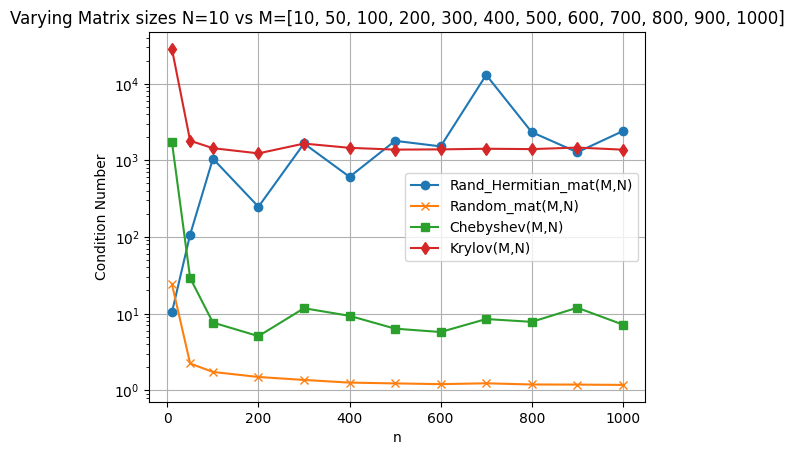

In [109]:
# Plot
plt.figure()
plt.plot(M, cond_H, label="Rand_Hermitian_mat(M,N)", marker="o")
plt.plot(M, cond_A, label="Random_mat(M,N)", marker="x")
plt.plot(M, cond_B, label="Chebyshev(M,N)", marker="s")
plt.plot(M, cond_C, label="Krylov(M,N)", marker="d")
plt.legend()
plt.yscale("log")
# plt.xscale("log")
plt.xlabel("n")
plt.ylabel("Condition Number")
plt.title(f"Varying Matrix sizes {N=} vs {M=}", fontsize=12)
plt.grid()
plt.show()

In [110]:
M=100
N=[5, 10, 15, 20 ,25, 30, 35, 50]
cond_H_=[]
cond_A_=[]
cond_B_=[]
cond_C_=[]
for i in N:
    a,b,c,d = condition_number(M,i)
    cond_H_.append(a)
    cond_A_.append(b)
    cond_B_.append(c)
    cond_C_.append(d)

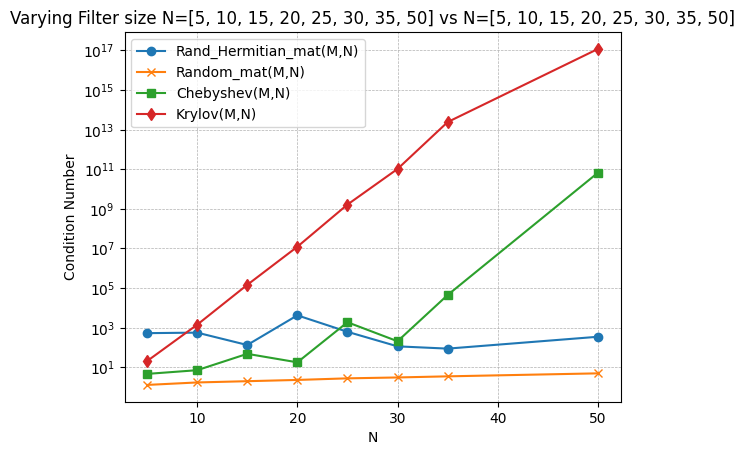

In [111]:
#Plot
plt.figure()
plt.plot(N, cond_H_, label="Rand_Hermitian_mat(M,N)", marker="o")
plt.plot(N, cond_A_, label="Random_mat(M,N)", marker="x")
plt.plot(N, cond_B_, label="Chebyshev(M,N)", marker="s")
plt.plot(N, cond_C_, label="Krylov(M,N)", marker="d")
plt.legend()
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("Condition Number")
plt.title(f"Varying Filter size {N=} vs {N=}", fontsize=12)
plt.grid( linestyle='--', linewidth=0.5)
plt.show()

## Comparison of Cholesky Factorization, Diagonalization and Hybrid Methods for Solving EVP

In [9]:
def lookup(b):
    if b <=500:
        return 24
    elif b<=750:
        return 30
    elif b<=1000:
        return 39
    elif b<=1500:
        return 50
    elif b<=2000:
        return 53
    elif b<=3000:
        return 57
    elif b<=4000:
        return 62
    elif b<=5000:
        return 69
    elif b<=9000:
        return 77
    elif b<=14000:
        return 104
    elif b<=20000:
        return 119
    elif b<=30000:
        return 162
    elif b<=50000:
        return 300
    elif b<=80000:
        return 450
    elif b<=100000:
        return 550
    elif b<=200000:
        return 700
    elif b<=500000:
        return 1000

In [10]:
# Generate a Real Symmetric Matrix
def generate_hermitian_matrix(M):
    """Generates an M x M random Hermitian matrix."""
    # H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
    # H = 0.5 * (H + H.conj().T)  # Ensure Hermitian

    # Generate a synthetic matrix H_ij = exp(-0.5 *|i-j|) * sin(i+1)
    i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
    H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
    # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
    return H

def Chebyshev_poly(H, a, b, k):
    """Computes the k-th order Chebyshev polynomial T_k(H)."""
    M = H.shape[0]
    H = (H - ((a + b) / 2) * np.eye(M)) / ((b - a) / 2)  # Normalize eigenvalues

    T_curr = np.eye(M)  
    T_next = H.copy()  # Avoid aliasing

    for _ in range(2, k + 1):
        T_new = 2 * H @ T_next - T_curr
        T_curr, T_next = T_next, T_new  # Efficient swapping

    return T_next

def Chebyshev_scalar_poly(x, a, b, k):
    """Computes the k-th order Chebyshev polynomial T_k(x)."""
    coeffs = np.zeros(k + 1)
    coeffs[k] = 1  # Set T_k coefficient to 1
    return chebval((x-((a+b)/2))/((b-a)/2), coeffs)

# Classical ChFSI Methods (Diagonalization, Cholesky and Hybrid)

#### Method 1: Diagonalization

In [47]:
# def generalized_eigenproblem(H, S):
#     """ Solves the generalized eigenvalue problem H X = S X Lambda """

#     # # Regularization to make S positive definite
#     # S += np.eye(S.shape[0]) * 1e-10

#     # Cholesky decomposition of S (S = L L^T)
#     L = np.linalg.cholesky(S)
    
#     # Transform H to standard eigenvalue problem
#     Linv = np.linalg.inv(L)
#     H_tilde = Linv @ H @ Linv.conj().T  # Equivalent to L^{-1} H L^{-dag}

#     # Solve standard eigenvalue problem
#     eigenvals, Q = np.linalg.eigh(H_tilde)

#     # Recover original eigenvectors
#     eigenvecs = np.linalg.inv(L.conj().T) @ Q

#     return eigenvals, eigenvecs

def ChFSI_diagalgo(H, Psi, T_kH):

        # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Projected Matrix
        H_proj = Psi_F.conj().T @ H @ Psi_F

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F
        
        # Diagonalization
        # eigenvals, eigvecs = generalized_eigenproblem(H_proj, S)
        # eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)
        try:
            eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)
        except np.linalg.LinAlgError:
            print("Warning: S not positive definite. Applying regularization.")
            eps = 1e-10
            S += eps * np.eye(S.shape[0])
            eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)

  
        # orthogonalization
        Psi = Psi_F @ eigvecs

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = Psi[:,idx]

        return eigenvals, eigenvecs


def ChFSI_diag(Psi, H, k = 24, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)
    
    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Diagonalization Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print()

    
    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_diagalgo(H, Psi, T_kH)

        Psi = eigenvecs

        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))

        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

#### Method 2: Cholesky Factorization

In [48]:
def ChFSI_cholalgo(H, Psi, T_kH):
        
        # Chebyshev Filtering
        Psi_F = T_kH @ Psi

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F

        # Regularization to ensure positive definiteness
        # S += np.eye(S.shape[0]) * 1e-10
        try:
            L = np.linalg.cholesky(S)
        except np.linalg.LinAlgError:
            print("Warning: S not positive definite. Applying regularization.")
            eps = 1e-10
            S += eps * np.eye(S.shape[0])
            L = np.linalg.cholesky(S)

 
        #Cholesky decomposition
        # L = np.linalg.cholesky(S)
        
        # orthogonalization
        Psi = Psi_F @ (np.linalg.inv(L).conj().T)
        
        eigenvals = np.einsum('ji,jk,ki->i', Psi.conj(), H, Psi)
        eigenvecs = Psi

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:,idx]

        return eigenvals, eigenvecs


def ChFSI_chol(Psi, H, k = 24, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian Matrix
    # N is the number of eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    #Initializing matrices and variables
    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)

    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H,a,b,k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Cholesky Decomposition Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_cholalgo(H, Psi, T_kH)
        Psi = eigenvecs

        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))

        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

#### Method 3: Hybrid Method

In [49]:
def ChFSI_hybd(Psi, H, k = 24, Ntilde = 10, buffer = 20, l = 10, epsilon = 1e-16, max_iter = 100):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter
    # a is the period of algorithm to be used

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    #Initializing matrices and variables
    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)
    
    eigenvalsh = np.linalg.eigvalsh(H)
    a_0, b = np.min(eigenvalsh), np.max(eigenvalsh)

    a_L = a_0
    k = lookup(b)
    a = (((b - a_0)/M)*N) + a_0
    T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)

    print()
    print("ChFSI with Hybrid Method Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Degree of Chebyshev Polynomial: {k}")
    print(f"Upper bound of Spectrum b = ", b)
    print(f"Lower bound of Spectrum a_0 = ", a_0)
    print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    print(f"a_L = ", a_L)
    print("The period of algorithm is ", l)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:
        
        if (((itr % l) == 0) or ((itr+1)==max_iter)) and (itr!=0):
            eigenvals, eigenvecs = ChFSI_diagalgo(H, Psi, T_kH)
        else:
            eigenvals, eigenvecs = ChFSI_cholalgo(H, Psi,T_kH)
            
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        a = np.max(eigenvals)
        T_kH = Chebyshev_poly(H, a, b, k) / Chebyshev_scalar_poly(a_L, a, b, k)
        itr+=1

    return eigenvals, eigenvecs, itr, residual

# Quantum methods

## Quantum Imaginary Time Evolution (QITE)

#### Non-Krylov Basis and QITE filtering solved using Diagonalization, Cholesky and Hybrid methods

In [3]:
def QITE_nonKry_qitefilter_diag(Psi, H, tau, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize = False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # tau is the imaginary time step
    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    # eigenvalsh = np.sort(np.linalg.eigvalsh(H))
    # deltaEL = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0])
    # tau = np.pi/deltaEL
    
    if normalize:
        # Normalize Psi
        b = np.max(np.abs(np.linalg.eigvalsh(H)))
        H_new = H/b
    else:
        H_new = H

    exp_H = expm(-H_new*tau)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)

    print()
    print("Quantum Imaginary Time Evolution Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_diagalgo(H_new, Psi, exp_H)
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [4]:
def QITE_nonKry_qitefilter_chol(Psi, H, tau, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize = False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    # eigenvalsh = np.sort(np.linalg.eigvalsh(H))
    # deltaEL = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0])
    # tau = np.pi/deltaEL
    if normalize:
        # Normalize Psi
        b = np.max(np.abs(np.linalg.eigvalsh(H)))
        H_new = H/b
    else:
        H_new = H

    exp_H = expm(-H_new*tau)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)

    print()
    print("Quantum Imaginary Diagonalization Cholesky Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_cholalgo(H_new, Psi,exp_H)
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [5]:
def QITE_nonKry_qitefilter_hybd(Psi, H, tau, Ntilde = 10, buffer = 20, l = 10, epsilon = 1e-16, max_iter = 100, normalize = False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found
    # k is the degree of the Chebyshev polynomial filter
    # a is the period of algorithm to be used

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    # eigenvalsh = np.sort(np.linalg.eigvalsh(H))
    # deltaEL = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0])
    # tau = np.pi/deltaEL
    if normalize:
        # Normalize Psi
        b = np.max(np.abs(np.linalg.eigvalsh(H)))
        H_new = H/b
    else:
        H_new = H
        
    exp_H = expm(-H_new*tau)

    #Initializing matrices and variables
    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvecs = np.empty((M,N),dtype=complex)

    print()
    print("QITE with Hybrid Method Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print(f"The period of algorithm is ", l)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:
        
        if (((itr % l) == 0) or ((itr+1)==max_iter)) and (itr!=0):
            eigenvals, eigenvecs = ChFSI_diagalgo(H_new, Psi, exp_H)
        else:
            eigenvals, eigenvecs = ChFSI_cholalgo(H_new, Psi, exp_H)
            
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

#### QITE Krylov Basis and no filter Solved using Diagonalization only (can be done with and without normalization of matrix)

In [6]:
def QITE_call(exp_H, N, v_0):
    
    M = exp_H.shape[0]
    # N is the number of eigenvalues to be found
    # M is the dimension of H matrix
    Psi = np.empty((M,N),dtype=complex)
    for i in range(N):
        # COmpute matix power
        Psi[:,i] = (np.linalg.matrix_power(exp_H, i) @ v_0).flatten()

    return Psi

def QITE_kry_nofilter_diag(H, Psi):
    # No Filtering
    Psi_F = Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F

    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)  # Let this raise an error if S is not PD

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigvecs[:, idx]

    return eigenvals, eigenvecs


def QITE_krylov_nofilter_diag(H, v_0, tau, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        eigenvalsh = (1 / b) * eigenvalsh[:N]
        H_new = H / b
    else:
        H_new = H
        eigenvalsh = eigenvalsh[:N]

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:
        Psi = QITE_call(exp_H, N + itr, v_0)
        print(f"{itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi)}")

        try:
            eigenvals, eigenvecs = QITE_kry_nofilter_diag(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        itr += 1

    return eigenvals, eigenvecs, itr, residual


#### QITE Krylov basis and no filter solved with Orthogonailation

In [18]:
def QITE_kry_nofilter_diag_ortho(H, Psi):
    # No Filtering
    Psi_F = Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F

    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)  # Let this raise an error if S is not PD

    # ORthogonalization
    Psi = Psi_F @ eigvecs

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = Psi[:, idx]

    return eigenvals, eigenvecs


def QITE_krylov_nofilter_diag_ortho(H, v_0, tau, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QITE_kry_nofilter_diag_ortho(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

In [19]:
def QITE_kry_nofilter_chol_ortho(H, Psi):
        # No Filtering
        Psi_F = Psi

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F

        # Regularization to ensure positive definiteness
        # S += np.eye(S.shape[0]) * 1e-10
        try:
            L = np.linalg.cholesky(S)
        except np.linalg.LinAlgError:
            print("Warning: S not positive definite. Applying regularization.")
            eps = 1e-10
            S += eps * np.eye(S.shape[0])
            L = np.linalg.cholesky(S)

 
        #Cholesky decomposition
        # L = np.linalg.cholesky(S)
        
        # orthogonalization
        Psi = Psi_F @ (np.linalg.inv(L).conj().T)
        
        eigenvals = np.einsum('ji,jk,ki->i', Psi.conj(), H, Psi)
        eigenvecs = Psi

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:,idx]

        return eigenvals, eigenvecs


def QITE_krylov_nofilter_chol_ortho(H, v_0, tau, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QITE_kry_nofilter_chol_ortho(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

In [20]:
def QITE_krylov_nofilter_hybd_ortho(H, v_0, tau, l, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        if (((itr % l) == 0) or ((itr + 1) == max_iter)) and (itr != 0):
            try:
                eigenvals, eigenvecs = QITE_kry_nofilter_diag_ortho(H_new, Psi)
            except np.linalg.LinAlgError as e:
                print(f"Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, last_valid_eigenvecs, itr, residual
        else:
            try:
                eigenvals, eigenvecs = QITE_kry_nofilter_chol_ortho(H_new, Psi)
            except np.linalg.LinAlgError as e:
                print(f"Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

#### QITE Krylov basis and QITE Filter solved with Orthogonalization

In [35]:
def QITE_kry_qitefilter_diag_ortho(H, Psi, exp_H):
    # No Filtering
    Psi_F = exp_H @ Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F

    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)  # Let this raise an error if S is not PD

    # ORthogonalization
    Psi = Psi_F @ eigvecs

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = Psi[:, idx]

    return eigenvals, eigenvecs


def QITE_krylov_qitefilter_diag_ortho(H, v_0, tau, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QITE_kry_qitefilter_diag_ortho(H_new, Psi, exp_H)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

In [36]:
def QITE_kry_qitefilter_chol_ortho(H, Psi, exp_H):
        # No Filtering
        Psi_F = exp_H @ Psi

        # Overlap Matrix
        S = Psi_F.conj().T @ Psi_F

        # Regularization to ensure positive definiteness
        # S += np.eye(S.shape[0]) * 1e-10
        try:
            L = np.linalg.cholesky(S)
        except np.linalg.LinAlgError:
            print("Warning: S not positive definite. Applying regularization.")
            eps = 1e-10
            S += eps * np.eye(S.shape[0])
            L = np.linalg.cholesky(S)

 
        #Cholesky decomposition
        # L = np.linalg.cholesky(S)
        
        # orthogonalization
        Psi = Psi_F @ (np.linalg.inv(L).conj().T)
        
        eigenvals = np.einsum('ji,jk,ki->i', Psi.conj(), H, Psi)
        eigenvecs = Psi

        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:,idx]

        return eigenvals, eigenvecs


def QITE_krylov_qitefilter_chol_ortho(H, v_0, tau, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QITE_kry_qitefilter_chol_ortho(H_new, Psi, exp_H)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

In [37]:
def QITE_krylov_qitefilter_hybd_ortho(H, v_0, tau, l, Ntilde=10, buffer=20, epsilon=1e-16, max_iter=100, normalize=True):
    M = H.shape[0]
    N = int((1 + (buffer / 100)) * Ntilde)

    itr = 0
    residual = [1e16]
    eigenvals = np.empty((N), dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    tau = tau
    exp_H = expm(-H_new * tau)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    if normalize: print(f"Upper bound of Spectrum b = {b}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    Psi = QITE_call(exp_H, N, v_0)

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    while itr < max_iter and residual[itr] >= epsilon:

        if (((itr % l) == 0) or ((itr + 1) == max_iter)) and (itr != 0):
            try:
                eigenvals, eigenvecs = QITE_kry_qitefilter_diag_ortho(H_new, Psi, exp_H)
            except np.linalg.LinAlgError as e:
                print(f"Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, last_valid_eigenvecs, itr, residual
        else:
            try:
                eigenvals, eigenvecs = QITE_kry_qitefilter_chol_ortho(H_new, Psi, exp_H)
            except np.linalg.LinAlgError as e:
                print(f"Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs

        # residual.append(np.linalg.norm(eigenvals[:Ntilde] - eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr += 1

    return eigenvals, eigenvecs, itr, residual

## Quantum Filter Diagonalization (QFD)

#### QFD Krylov Basis and no Filter Solved using Diagonalization only

In [303]:
def QFD_call(exp_H, N, v_0):
    
    M = exp_H.shape[0]
    # N is the number of eigenvalues to be found
    # M is the dimension of H matrix
    Psi = np.empty((M,N),dtype=complex)
    # Range goes from -N/2 to N/2
    for i in range(N):
        # Shift the range to be from 0 to N-1
        i_n = i - N//2
        Psi[:, i] = (np.linalg.matrix_power(exp_H, i_n) @ v_0).flatten()

    return Psi

def QFD_kry_nofilter_diag(H, Psi):

    # No Filtering
    Psi_F = Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    
    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)
    # eigenvals, eigvecs = generalized_eigenproblem(H_proj, S)

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigvecs[:,idx]

    return eigenvals, eigenvecs

def QFD_krylov_nofilter_diag(H, v_0, tau, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=True):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        eigenvalsh = (1 / b) * eigenvalsh[:N]
        H_new = H / b
    else:
        H_new = H
        eigenvalsh = eigenvalsh[:N]

    # 
    # b = np.max(np.abs(eigenvalsh))  # Normalize H to have eigenvalues in [-1, 1]
    # eigenvalsh = (1/b)*eigenvalsh[:N]
    # eigenvalsh = eigenvalsh[:N]

    # H_new = -H/b
    # H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = (np.pi/deltaEL) * tau
    exp_H = expm(-1.j *H_new*tau)

    print()
    print("QFD Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        Psi = QFD_call(exp_H, N+itr, v_0)
        # Print condition number of Psi
        print(f"{itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi)}")

        try:
            eigenvals, eigenvecs = QFD_kry_nofilter_diag(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs
        
        residual.append(np.linalg.norm(eigenvals[:Ntilde]-eigenvalsh[:Ntilde], ord=np.inf))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

#### QFD Krylov basis and no Filter solved with orthogonalization

In [339]:
def QFD_kry_nofilter_diag_ortho(H, Psi):

    # No Filtering
    Psi_F = Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    
    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)
    # eigenvals, eigvecs = generalized_eigenproblem(H_proj, S)

    # Orthogonalization
    Psi = Psi_F @ eigvecs

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = Psi[:,idx]

    return eigenvals, eigenvecs

def QFD_krylov_nofilter_diag_ortho(H, v_0, tau, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=True):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        eigenvalsh = (1 / b) * eigenvalsh[:N]
        H_new = H / b
    else:
        H_new = H
        eigenvalsh = eigenvalsh[:N]

    # b = np.max(np.abs(eigenvalsh))  # Normalize H to have eigenvalues in [-1, 1]
    # eigenvalsh = (1/b)*eigenvalsh[:N]
    # eigenvalsh = eigenvalsh[:N]

    # H_new = -H/b
    # H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = (np.pi/deltaEL) * tau
    exp_H = expm(-1.j*H_new*tau)

    Psi = QFD_call(exp_H, N, v_0)

    print()
    print("QFD Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QFD_kry_nofilter_diag_ortho(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs
        
        # residual.append(np.linalg.norm(eigenvals[:Ntilde]-eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [338]:
def QFD_kry_nofilter_chol_ortho(H, Psi):

    # No Filtering
    Psi_F = Psi

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    
    #Cholesky decomposition
    L = np.linalg.cholesky(S)
    
    # orthogonalization
    Psi = Psi_F @ (np.linalg.inv(L).conj().T)
    
    eigenvals = np.einsum('ji,jk,ki->i', Psi.conj(), H, Psi)
    eigenvecs = Psi

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:,idx]

    return eigenvals, eigenvecs

def QFD_krylov_nofilter_chol_ortho(H, v_0, tau, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=True):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        eigenvalsh = (1 / b) * eigenvalsh[:N]
        H_new = H / b
    else:
        H_new = H
        eigenvalsh = eigenvalsh[:N]

    # b = np.max(np.abs(eigenvalsh))  # Normalize H to have eigenvalues in [-1, 1]
    # eigenvalsh = (1/b)*eigenvalsh[:N]
    # eigenvalsh = eigenvalsh[:N]

    # H_new = -H/b
    # H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = (np.pi/deltaEL) * tau
    exp_H = expm(-1.j*H_new*tau)

    Psi = QFD_call(exp_H, N, v_0)

    print()
    print("QFD Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        try:
            eigenvals, eigenvecs = QFD_kry_nofilter_chol_ortho(H_new, Psi)
        except np.linalg.LinAlgError as e:
            print(f"Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, itr, residual

        Psi = eigenvecs

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = eigenvecs
        
        # residual.append(np.linalg.norm(eigenvals[:Ntilde]-eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [337]:
def QFD_krylov_nofilter_hybd_ortho(H, v_0, tau, l=10, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=True):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        eigenvalsh = (1 / b) * eigenvalsh[:N]
        H_new = H / b
    else:
        H_new = H
        eigenvalsh = eigenvalsh[:N]

    # b = np.max(np.abs(eigenvalsh))  # Normalize H to have eigenvalues in [-1, 1]
    # eigenvalsh = (1/b)*eigenvalsh[:N]
    # eigenvalsh = eigenvalsh[:N]

    # H_new = -H/b
    # H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = (np.pi/deltaEL) * tau
    exp_H = expm(-1.j*H_new*tau)

    Psi = QFD_call(exp_H, N, v_0)

    print()
    print("QFD Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Tau: {tau}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        if (((itr % l) == 0) or ((itr+1)==max_iter)) and (itr!=0):
            eigenvals, eigenvecs = QFD_kry_nofilter_diag_ortho(H_new, Psi)
        else:
            eigenvals, eigenvecs = QFD_kry_nofilter_chol_ortho(H_new, Psi)
            
        Psi = eigenvecs
        
        # residual.append(np.linalg.norm(eigenvals[:Ntilde]-eigenvalsh[:Ntilde], ord=np.inf))
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

#### QFD non-Krylov basis and QFD filter solved using Diagonalization, Cholesky, Hybrid Methods

In [314]:
def QFD_nonKry_qfdfilter_diag(Psi, H, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = np.pi/deltaEL
    exp_H = expm(-1.j *H_new*tau)

    print()
    print("Quantum Imaginary Time Evolution Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_diagalgo(H_new, Psi, exp_H)
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [315]:
def QFD_nonKry_qfdfilter_chol(Psi, H, Ntilde = 10, buffer = 20, epsilon = 1e-16, max_iter = 100, normalize=False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = np.pi/deltaEL
    exp_H = expm(-1.j *H_new*tau)

    print()
    print("Quantum Imaginary Time Evolution Diagonalization Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:

        eigenvals, eigenvecs = ChFSI_cholalgo(H_new, Psi, exp_H)
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

In [334]:
def QFD_nonKry_qfdfilter_hybd(Psi, H, Ntilde = 10, buffer = 20, l = 10, epsilon = 1e-16, max_iter = 100, normalize=False):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # Print Rank of Psi Matrix
    # print(f"Rank of Psi Matrix: {np.linalg.matrix_rank(Psi)}")

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)
    eigenvalsh = np.sort(np.linalg.eigvalsh(H))

    if normalize:
        b = np.max(np.abs(eigenvalsh))
        H_new = H / b
    else:
        H_new = H

    deltaEL = np.abs(eigenvalsh[N-1] - eigenvalsh[0])
    tau = np.pi/deltaEL
    exp_H = expm(-1.j *H_new*tau)

    print()
    print("QITE with Hybrid Method Parameters")
    print(f"Dimension of H matrix: {M}")
    print(f"Space Size: {N}")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Normalize Matrix: {normalize}")
    print(f"tau = ", tau)
    print(f"The period of algorithm is ", l)
    print()

    # Algorithm
    while itr < max_iter and residual[itr] >= epsilon:
        
        if (((itr % l) == 0) or ((itr+1)==max_iter)) and (itr!=0):
            eigenvals, eigenvecs = ChFSI_diagalgo(H_new, Psi, exp_H)
        else:
            eigenvals, eigenvecs = ChFSI_cholalgo(H, Psi)
        Psi = eigenvecs
        residual.append(np.max(np.linalg.norm(H_new @ eigenvecs[:,:Ntilde] - eigenvecs[:,:Ntilde] @ np.diag(eigenvals[:Ntilde]), axis=0, ord=2)))
        itr+=1

    return eigenvals, eigenvecs, itr, residual

## Chebyshev Quantum Krylov

#### Chebyshev Krylov Basis and no filter solved using Diagonalization only

In [ ]:
def Cheby_call(H, N, v_0):
    
    M = H.shape[0]

    Psi = np.empty((M, N), dtype=np.complex128)
    Psi[:,0] = v_0.flatten()  # Initial vector
    Psi[:,1] = (H @ v_0).flatten()  # H*v_0

    # T_kprev = 1
    # T_kcurr = b
    T_prev = np.eye(M)  # T_0 = I
    T_curr = H          # T_1 = H

    for i in range(2, N):
        # Compute Chebyshev polynomials iteratively
        T_next = (2 * H) @ T_curr - T_prev
        Psi[:,i] = (T_next @ v_0).flatten()
        T_prev, T_curr = T_curr, T_next  # Move forward in recurrence

    return Psi

def Cheby_kry_nofilter_diag(H, Psi):

    # No Filtering
    Psi_F = Psi

    # Projected Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    
    # Diagonalization
    eigenvals, eigvecs = scipy.linalg.eigh(H_proj, S)
    # eigenvals, eigvecs = generalized_eigenproblem(H_proj, S)

    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigvecs[:,idx]

    return eigenvals, eigenvecs


def Cheby_krylov_nofilter_diag(H, v_0, Ntilde = 10, buffer = 20, epsilon = 1e-5, max_iter = 100):
    # H is a Hermitian matrix
    # N is the eigenvalues to be found

    # M is the dimension of H matrix
    M = H.shape[0]
    N = int((1+(buffer/100)) * Ntilde)

    itr=0
    residual = [1e16]
    eigenvals = np.empty((N),dtype=complex)

    eigenvalsh = np.sort(np.linalg.eigvalsh(H))
    b = np.max(np.abs(eigenvalsh))  # Normalize H to have eigenvalues in [-1, 1]
    eigenvalsh = (1/b)*eigenvalsh[:N]
    # eigenvalsh = eigenvalsh[:N]

    H_new = -H/b
    # H_new = H

    print()
    print("Chebyshev Krylov with Diagonalization Parameters")
    print(f"Number of Eigenvalues: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    # print(f"Degree of Chebyshev Polynomial: {k}")
    # print(f"Upper bound of Spectrum b = ", b)
    # print(f"Lower bound of Spectrum a_0 = ", a_0)
    # print(F"Initial guess of Lower bound of wanted spectrum a = ", a)
    # print(f"a_L = ", a_L)
    print()

    
    # Algorithm
    while (N + itr) < max_iter and residual[itr] >= epsilon:

        # Compute Chebyshev polynomials iteratively
        Psi = Cheby_call(H_new, N+itr, v_0)
        eigenvals, eigenvecs = Cheby_kry_nofilter_diag(H_new, Psi)
        # Print condition number of Psi
        print(f"{itr} Condition Number of Psi Matrix: {np.linalg.cond(Psi)}")
        residual.append(np.linalg.norm(eigenvals[:Ntilde]-eigenvalsh[:Ntilde], ord=np.inf))
        itr+=1
        
    return eigenvals, eigenvecs, itr, residual

## Analysis

In [52]:
# Parameters
M =  100 # Dimension of the matrix
Ntilde = 5  # Number of eigenvalues
buffer = 20  # Buffer for the number of eigenvalues
N = int((1+(buffer/100)) * Ntilde)  # Number of eigenvalues to be found
Psi = np.random.randn(M, N) + 1j * np.random.randn(M,N)
Psi /= np.linalg.norm(Psi, axis=0, keepdims=True)
v_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
v_0 /= np.linalg.norm(v_0, axis=0, keepdims=True)
k = 24  # Degree of Chebyshev polynomial
epsilon = 1e-12  # Tolerance for convergence
max_iter = 100 # Maximum number of iterations
tau = 1e+1 # Time step for QITE
l = 5 # Period of the algorithm for Hybrid Algorithm
H = generate_hermitian_matrix(M)

print("Matrix Size: ", M)
print("Number of Eigenvalues: ", Ntilde)
print("Buffer: ", buffer)
print("Initial space size: ", N)
print("Degree of Chebyshev Polynomial: ", k)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)
print("Period of Algorithm: ", l)
print("Time Step for QITE tau: ", tau)

Matrix Size:  100
Number of Eigenvalues:  5
Buffer:  20
Initial space size:  6
Degree of Chebyshev Polynomial:  24
Convergence Threshold:  1e-12
Max Iterations:  100
Period of Algorithm:  5
Time Step for QITE tau:  10.0


In [53]:
# Solving the problem
# eigenvals_chol, eigenvecs_chol, itr_chol, residual_chol = ChFSI_chol(Psi, H, k, Ntilde, buffer, epsilon, max_iter)
# eigenvals_diag, eigenvecs_diag, itr_diag, residual_diag = ChFSI_diag(Psi, H, k, Ntilde, buffer, epsilon, max_iter)
# eigenvals_hybd, eigenvecs_hybd, itr_hybd, residual_hybd = ChFSI_hybd(Psi, H, k, Ntilde, buffer, l, epsilon, max_iter)
eigenvals_QITE_nonKry_qitefilter_diag, eigenvecs_QITE_nonKry_qitefilter_qitediag, itr_QITE_nonKry_qitefilter_diag, residual_QITE_nonKry_qitefilter_diag = QITE_nonKry_qitefilter_diag(Psi, H, tau,Ntilde, buffer, epsilon, max_iter, False)
eigenvals_QITE_nonKry_qitefilter_chol, eigenvecs_QITE_nonKry_qitefilter_qitechol, itr_QITE_nonKry_qitefilter_chol, residual_QITE_nonKry_qitefilter_chol = QITE_nonKry_qitefilter_chol(Psi, H, tau, Ntilde, buffer, epsilon, max_iter, False)
eigenvals_QITE_nonKry_qitefilter_hybd, eigenvecs_QITE_nonKry_qitefilter_qitehybd, itr_QITE_nonKry_qitefilter_hybd, residual_QITE_nonKry_qitefilter_hybd = QITE_nonKry_qitefilter_hybd(Psi, H, tau, Ntilde, buffer, l, epsilon, max_iter, False)
# eigenvals_qite_krylov_nofilter_diag, eigenvecs_qite_krylov_nofilter_diag, itr_qite_krylov_nofilter_diag, residual_qite_krylov_nofilter_diag = QITE_krylov_nofilter_diag(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qite_krylov_nofilter_diag_ortho, eigenvecs_qite_krylov_nofilter_diag_ortho, itr_qite_krylov_nofilter_diag_ortho, residual_qite_krylov_nofilter_diag_ortho = QITE_krylov_nofilter_diag_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qite_krylov_nofilter_chol_ortho, eigenvecs_qite_krylov_nofilter_chol_ortho, itr_qite_krylov_nofilter_chol_ortho, residual_qite_krylov_nofilter_chol_ortho = QITE_krylov_nofilter_chol_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qite_krylov_nofilter_hybd_ortho, eigenvecs_qite_krylov_nofilter_hybd_ortho, itr_qite_krylov_nofilter_hybd_ortho, residual_qite_krylov_nofilter_hybd_ortho = QITE_krylov_nofilter_hybd_ortho(H, v_0, tau, l, Ntilde, buffer, epsilon, max_iter, False)
eigenvals_qite_krylov_qitefilter_diag_ortho, eigenvecs_qite_krylov_qitefilter_diag_ortho, itr_qite_krylov_qitefilter_diag_ortho, residual_qite_krylov_qitefilter_diag_ortho = QITE_krylov_qitefilter_diag_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
eigenvals_qite_krylov_qitefilter_chol_ortho, eigenvecs_qite_krylov_qitefilter_chol_ortho, itr_qite_krylov_qitefilter_chol_ortho, residual_qite_krylov_qitefilter_chol_ortho = QITE_krylov_qitefilter_chol_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
eigenvals_qite_krylov_qitefilter_hybd_ortho, eigenvecs_qite_krylov_qitefilter_hybd_ortho, itr_qite_krylov_qitefilter_hybd_ortho, residual_qite_krylov_qitefilter_hybd_ortho = QITE_krylov_qitefilter_hybd_ortho(H, v_0, tau, l, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_krylov_nofilter_diag, eigenvecs_qfd_krylov_nofilter_diag, itr_qfd_krylov_nofilter_diag, residual_qfd_krylov_nofilter_diag = QFD_krylov_nofilter_diag(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_krylov_nofilter_diag_ortho, eigenvecs_qfd_krylov_nofilter_diag_ortho, itr_qfd_krylov_nofilter_diag_ortho, residual_qfd_krylov_nofilter_diag_ortho = QFD_krylov_nofilter_diag_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_krylov_nofilter_chol_ortho, eigenvecs_qfd_krylov_nofilter_chol_ortho, itr_qfd_krylov_nofilter_chol_ortho, residual_qfd_krylov_nofilter_chol_ortho = QFD_krylov_nofilter_chol_ortho(H, v_0, tau, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_krylov_nofilter_hybd_ortho, eigenvecs_qfd_krylov_nofilter_hybd_ortho, itr_qfd_krylov_nofilter_hybd_ortho, residual_qfd_krylov_nofilter_hybd_ortho = QFD_krylov_nofilter_hybd_ortho(H, v_0, tau, l, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_nonKry_qfdfilter_diag, eigenvecs_qfd_nonKry_qfdfilter_diag, itr_qfd_nonKry_qfdfilter_diag, residual_qfd_nonKry_qfdfilter_diag = QFD_nonKry_qfdfilter_diag(Psi, H, Ntilde, buffer, epsilon, max_iter, False)
# eigenvals_qfd_nonKry_qfdfilter_chol, eigenvecs_qfd_nonKry_qfdfilter_chol, itr_qfd_nonKry_qfdfilter_chol, residual_qfd_nonKry_qfdfilter_chol = QFD_nonKry_qfdfilter_chol(Psi, H, Ntilde, buffer, epsilon, max_iter)
# eigenvals_qfd_nonKry_qfdfilter_hybd, eigenvecs_qfd_nonKry_qfdfilter_hybd, itr_qfd_nonKry_qfdfilter_hybd, residual_qfd_nonKry_qfdfilter_hybd = QFD_nonKry_qfdfilter_hybd(Psi, H, Ntilde, buffer, l, epsilon, max_iter)
# eigenvals_cHeby_krylov_diag, eigenvecs_cHeby_krylov_diag, itr_cHeby_krylov_diag, residual_cHeby_krylov_diag = Cheby_krylov_nofilter_diag(H, b, Ntilde, buffer, epsilon, max_iter)
eigenvals, eigenvecs = np.linalg.eigh(H)


Quantum Imaginary Time Evolution Diagonalization Parameters
Dimension of H matrix: 100
Space Size: 6
Number of Eigenvalues: 5
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 100
Normalize Matrix: False
tau =  10.0


Quantum Imaginary Diagonalization Cholesky Parameters
Dimension of H matrix: 100
Space Size: 6
Number of Eigenvalues: 5
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 100
Normalize Matrix: False
tau =  10.0


QITE with Hybrid Method Parameters
Dimension of H matrix: 100
Space Size: 6
Number of Eigenvalues: 5
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 100
Normalize Matrix: False
tau =  10.0
The period of algorithm is  5


QITE Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 100
Space Size: 6
Number of Eigenvalues: 5
Tau: 10.0
Buffer: 20%
Convergence Threshold: 1e-12
Max Iterations: 100
Normalize Matrix: False


QITE Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 100
Space Size: 6
Number of E

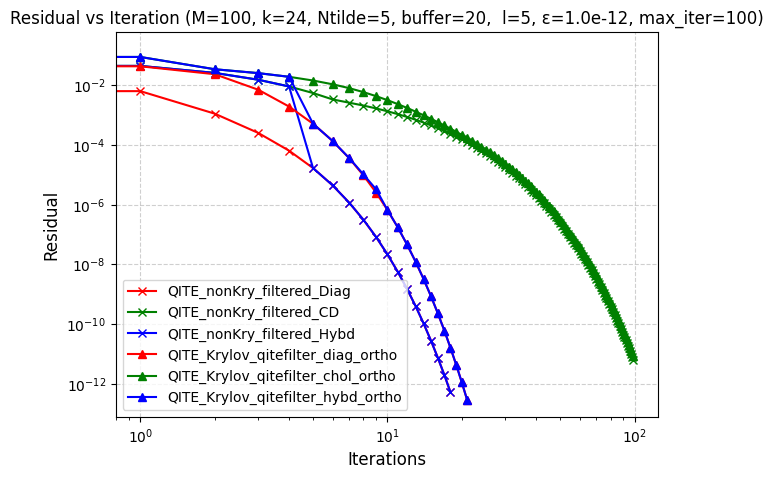

In [54]:
# Plot the error
plt.figure(figsize=(7, 5))
plt.title(f"Residual vs Iteration (M={M}, k={k}, Ntilde={Ntilde}, buffer={buffer},  l={l}, ε={epsilon:.1e}, max_iter={max_iter})")

# plt.plot(np.arange(len(residual_diag)-1), residual_diag[1:], marker='o',  label="ChFSI_Diag", color="red")
# plt.plot(np.arange(len(residual_chol)-1), residual_chol[1:], marker='o',  label="ChFSI_CD",color="green")
# plt.plot(np.arange(len(residual_hybd)-1), residual_hybd[1:], marker='o',  label="ChFSI_Hybd",color="blue")
plt.plot(np.arange(len(residual_QITE_nonKry_qitefilter_diag)-1), residual_QITE_nonKry_qitefilter_diag[1:], marker='x',  label="QITE_nonKry_filtered_Diag", color="red")
plt.plot(np.arange(len(residual_QITE_nonKry_qitefilter_chol)-1), residual_QITE_nonKry_qitefilter_chol[1:], marker='x',  label="QITE_nonKry_filtered_CD", color="green")
plt.plot(np.arange(len(residual_QITE_nonKry_qitefilter_hybd)-1), residual_QITE_nonKry_qitefilter_hybd[1:], marker='x',  label="QITE_nonKry_filtered_Hybd", color="blue")
# plt.plot(np.arange(len(residual_qite_krylov_nofilter_diag)-1), residual_qite_krylov_nofilter_diag[1:], marker='^', label="QITE_Krylov_qitefilter_diag", color="blue")
# plt.plot(np.arange(len(residual_qite_krylov_nofilter_diag_ortho)-1), residual_qite_krylov_nofilter_diag_ortho[1:], marker='^', label="QITE_Krylov_nofilter_diag_ortho", color="red")
# plt.plot(np.arange(len(residual_qite_krylov_nofilter_chol_ortho)-1), residual_qite_krylov_nofilter_chol_ortho[1:], marker='^', label="QITE_Krylov_nofilter_chol_ortho", color="blue")
# plt.plot(np.arange(len(residual_qite_krylov_nofilter_hybd_ortho)-1), residual_qite_krylov_nofilter_hybd_ortho[1:], marker='^', label="QITE_Krylov_nofilter_hybd_ortho", color="green")
plt.plot(np.arange(len(residual_qite_krylov_qitefilter_diag_ortho)-1), residual_qite_krylov_qitefilter_diag_ortho[1:], marker='^', label="QITE_Krylov_qitefilter_diag_ortho", color="red")
plt.plot(np.arange(len(residual_qite_krylov_qitefilter_chol_ortho)-1), residual_qite_krylov_qitefilter_chol_ortho[1:], marker='^', label="QITE_Krylov_qitefilter_chol_ortho", color="green")
plt.plot(np.arange(len(residual_qite_krylov_qitefilter_hybd_ortho)-1), residual_qite_krylov_qitefilter_hybd_ortho[1:], marker='^', label="QITE_Krylov_qitefilter_hybd_ortho", color="blue")
# plt.plot(np.arange(len(residual_qfd_krylov_nofilter_diag)-1), residual_qfd_krylov_nofilter_diag[1:], marker='^', label="QFD_Krylov", color="blue")
# plt.plot(np.arange(len(residual_qfd_krylov_nofilter_diag_ortho)-1), residual_qfd_krylov_nofilter_diag_ortho[1:], marker='^', label="QFD_Krylov_Ortho", color="red")
# plt.plot(np.arange(len(residual_qfd_krylov_nofilter_chol_ortho)-1), residual_qfd_krylov_nofilter_chol_ortho[1:], marker='^', label="QFD_Krylov_Ortho", color="blue")
# plt.plot(np.arange(len(residual_qfd_krylov_nofilter_hybd_ortho)-1), residual_qfd_krylov_nofilter_hybd_ortho[1:], marker='^', label="QFD_Krylov_Ortho", color="green")
# plt.plot(np.arange(len(residual_qfd_nonKry_qfdfilter_diag)-1), residual_qfd_nonKry_qfdfilter_diag[1:], marker='o', label="QFD_nonKry_filtered_Diag", color="red")
# plt.plot(np.arange(len(residual_qfd_nonKry_qfdfilter_chol)-1), residual_qfd_nonKry_qfdfilter_chol[1:], marker='o', label="QFD_nonKry_filtered_CD", color="green")
# plt.plot(np.arange(len(residual_qfd_nonKry_qfdfilter_hybd)-1), residual_qfd_nonKry_qfdfilter_hybd[1:], marker='o', label="QFD_nonKry_filtered_Hybd", color="blue")
# plt.plot(np.arange(len(residual_cHeby_krylov_diag)-1), residual_cHeby_krylov_diag[1:], marker='o', label="Cheby_Krylov (RAND_INIT)", color="black")

plt.yscale("log")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Residual", fontsize=12)
# Legend adjustments
plt.legend()
plt.show()

In [270]:
# print("Eigenvalues (Cholesky):", eigenvals_chol)
# print("Eigenvalues (Diagonalization):", eigenvals_diag)
# print("Eigenvalues (Hybrid):", eigenvals_hybd)
# print("Eigenvalues (QITE) non-Krylov qite filter diagonalization:", eigenvals_QITE_nonKry_qitefilter_diag)
# print("Eigenvalues (QITE) non-Krylov qite filter cholesky:", eigenvals_QITE_nonKry_qitefilter_chol)
# print("Eigenvalues (QITE) non-Krylov qite filter hybrid:", eigenvals_QITE_nonKry_qitefilter_hybd)
# print("Eigenvalues (QITE) Krylov basis no filter diagonalization:", eigenvals_qite_krylov_nofilter_diag[:Ntilde])
print("Eigenvalues (QFD) Krylov basis no filter diagonalization:", eigenvals_qfd_krylov_nofilter_diag[:Ntilde])
# print("Eigenvalues (Exact):", np.sort((1/np.max(np.abs(eigenvals)))*eigenvals)[:N])
# print("Eigenvalues (Exact):", (1/np.max(eigenvals))*eigenvals[:Ntilde])
print("Eigenvalues (Exact):", eigenvals[:Ntilde])

Eigenvalues (QFD) Krylov basis no filter diagonalization: [-0.2911071]
Eigenvalues (Exact): [-2.04824635]


In [ ]:
# print("Eigenvecs (Diagonalization):", eigenvecs_diag)
# print("Eigenvecs (Cholesky):", eigenvecs_chol)
# print("Eigenvecs (Hybrid):", eigenvecs_hybd)
# print("Eigenvecs (QITE Diagonalization):", eigenvecs_qitediag)
# print("Eigenvecs (QITE Cholesky):", eigenvecs_qitechol)
# print("Eigenvecs (QITE Hybrid):", eigenvecs_qitehybd)
print("Eigenvecs (Exact):", eigenvecs[:N])

Eigenvecs (Diagonalization): [[ 0.00458239-0.00588823j -0.00870709+0.01190786j -0.01904445-0.01018937j
  ...  0.05757554-0.01820358j -0.02350365+0.0588125j
  -0.00439296-0.06554353j]
 [-0.00184354+0.00236889j  0.00349434-0.00477888j  0.00761184+0.00407257j
  ... -0.02133375+0.00674506j  0.00855941-0.02141796j
   0.00156995+0.0234237j ]
 [-0.01458715+0.01874404j  0.02767816-0.03785279j  0.06039672+0.0323141j
  ... -0.17477112+0.05525715j  0.07062903-0.17673294j
   0.01305617+0.19479878j]
 ...
 [-0.01436531+0.01845898j -0.02727559+0.03730223j  0.05963524+0.03190669j
  ...  0.17007829-0.05377343j  0.06865232-0.17178668j
  -0.01267555-0.18912025j]
 [-0.00151457+0.00194618j -0.00287305+0.0039292j   0.00627193+0.00335567j
  ...  0.0173998 -0.00550127j  0.00698171-0.01747014j
  -0.00128097-0.01911214j]
 [ 0.00486871-0.00625614j  0.00925982-0.01266377j -0.02030214-0.01086227j
  ... -0.06100699+0.0192885j  -0.02492578+0.06237105j
   0.00466363+0.06958215j]]
Eigenvecs (Cholesky): [[-0.00636688+0